# Machine Learning Pipeline for Queen Bee Acoustic Monitoring Using CNN

A complete end-to-end prototype to detect **Queen Bee Presence** from **Hive audio recordings** using a Machine Learning pipeline.

---

## Live Demo (CNN prototype is in progress)
<div class="alert alert-block alert-success">
Note:
You can try the deployed model (Model used Random Forest Classifier in this prototype) and download a sample audio file to test it.

</div>

<span style="display: inline-block;">
  <a href="http://3.109.237.216">
    <img src="https://img.shields.io/badge/Live-Demo-blue" alt="Live Demo">
  </a>
</span>

<span style="display: inline-block;" >
<a href="https://drive.google.com/drive/folders/1KFmHH304soDKXbLvlohWBJ-qVzudjTgZ?usp=sharing">
    <img src="https://img.shields.io/badge/Google%20Drive-Sample%20Data-blue?logo=google-drive&logoColor=white" alt="Google Drive">
</a>
</span>
    
<span style="display: inline-block;">
<a href="https://github.com/Harsh-1711/BuzzDetect">
  <img src="https://img.shields.io/badge/GitHub-View%20Repository-blue?logo=github" alt="GitHub Repo">
</a>
</span>
<span style="display: inline-block;">
  <a href="https://drive.google.com/file/d/1XldGWp5G2Ecby9GLpalsgegvOgMsL_HJ/view?usp=sharing" target="_blank">
    <img src="https://img.shields.io/badge/Demo-Video-green?logo=google-drive" alt="Demo Video">
  </a>
</span>

---

This notebook demonstrates a complete pipeline for processing hive audio recordings and applying machine learning to detect the presence of the queen bee.
It covers audio feature extraction, dataset preparation, model training, evaluation, and inference.

In [1]:
"""
Import necessary libraries for the Queen Bee Detection project.

- os: For file and directory operations.
- numpy: For numerical operations on arrays and matrices.
- matplotlib & seaborn: For data visualization.
- librosa: For audio processing and feature extraction.
"""

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras_tuner as kt

import warnings
warnings.filterwarnings("ignore")

2025-12-21 10:06:48.548533: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-21 10:06:49.324559: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-21 10:06:53.012742: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## **1. Data Loading and Exploration**
#### 📌 Objective:
    Load the dataset dataset and plot a graph showing the total no. of dataset for each category.
    
<div class="alert alert-block alert-success">
    Dataset Source:
</div>
        
  - This dataset was originally sourced from https://zenodo.org/records/2667806.
  - It contains labeled audio recordings from beehives for Queen Bee detection.
  - Modified Dataset - https://www.kaggle.com/datasets/harshkumar1711/beehive-audio-dataset-with-queen-and-without-queen

In [2]:
#importing dataset from kaggle

for dirname, _, filenames in os.walk('/content/beehive_audio/7'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

QueenBee Present: 4000 files
QueenBee Absent: 2000 files
External Noise: 2000 files


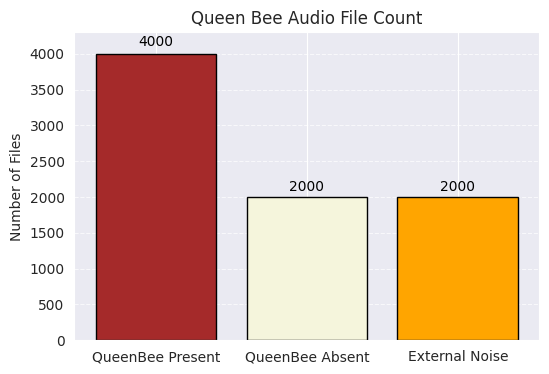

In [3]:

# Load base path
base_path = "./content/beehive_audio/7/Dataset/Bee Hive Audios"

# Include spaces prbboperly using raw string or quotes
present_path = os.path.join(base_path, "QueenBee Present")
absent_path = os.path.join(base_path, "QueenBee Absent")
external_path= './content/beehive_audio/7/Dataset/External Noise'

# Count .wav files
present_count = len([f for f in os.listdir(present_path) if f.endswith('.wav')])
absent_count = len([f for f in os.listdir(absent_path) if f.endswith('.wav')])
external_count = len([f for f in os.listdir(external_path) if f.endswith('.wav')])
# Print counts
print(f"QueenBee Present: {present_count} files")
print(f"QueenBee Absent: {absent_count} files")
print(f"External Noise: {external_count} files")

# Plot the counts
labels = ['QueenBee Present', 'QueenBee Absent','External Noise']
counts = [present_count, absent_count, external_count]

plt.figure(figsize=(6, 4))
plt.ylim(0, 4300)
bars=plt.bar(labels, counts, color=['brown', 'beige','orange'],edgecolor='black')
plt.grid(axis="y",linestyle="--",alpha=0.7)
for bar in bars:
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    plt.text(x, y+y ** 0.5, str(y), ha='center', va='bottom', fontsize=10, color='black')
plt.title("Queen Bee Audio File Count")
plt.ylabel("Number of Files")
plt.show()


In [ ]:
import tensorflow as tf

try:
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu_resolver)
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
    strategy = tf.distribute.TPUStrategy(tpu_resolver)
    ACCELERATOR = 'TPU'
except (ValueError, tf.errors.NotFoundError):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception:
                pass
        strategy = tf.distribute.MirroredStrategy()
        ACCELERATOR = f"{strategy.num_replicas_in_sync}xGPU"
    else:
        strategy = tf.distribute.get_strategy()
        ACCELERATOR = 'CPU'

print(f"Using {ACCELERATOR} via tf.distribute strategy: {strategy.__class__.__name__}")


## **2. Audio Preprocessing and Spectrogram Generation**
#### 📌 Objective:
    This section defines parameters for audio sampling and a function to convert `.wav` audio files into mel spectrogram images. The function performs the following steps:
    - Loads and trims the audio.
    - Normalizes the signal and ensures a fixed length.
    - Generates a mel spectrogram using Librosa.
    - Saves the spectrogram as a `.png` image for use in model training.

This is a key step in preparing audio data for convolutional neural networks (CNNs), which work better with visual inputs.

In [4]:
output_base = "./content/beehive_audio/7/Dataset/Spectograms"
os.makedirs(os.path.join(output_base, "present"), exist_ok=True)
os.makedirs(os.path.join(output_base, "absent"), exist_ok=True)
os.makedirs(os.path.join(output_base, "external"), exist_ok=True)


In [5]:
SAMPLE_RATE = 22050
DURATION = 3  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Function to process and save spectrograms
def preprocess_and_save_spectrogram(audio_path, output_image_path, sr=SAMPLE_RATE, duration=DURATION):

    """
    Load an audio file, convert it into a mel spectrogram, and save it as an image.

    Parameters:
    -----------
    audio_path : str
        Path to the input .wav audio file.
    output_image_path : str
        Path where the output spectrogram image will be saved.
    sr : int, optional
        Sampling rate for the audio. Default is 22050 Hz.
    duration : int, optional
        Duration (in seconds) to which the audio will be fixed. Default is 3 seconds.

    Steps:
    ------
    1. Load and trim silence from the audio.
    2. Convert to mono and normalize the waveform.
    3. Pad or truncate to fixed duration.
    4. Generate a mel spectrogram.
    5. Convert the power spectrogram to decibels.
    6. Save the spectrogram as a `.png` image (suitable for CNN input).

    Exceptions:
    -----------
    If any error occurs during processing, the function will print an error message.
    """

    try:
        y, _ = librosa.load(audio_path, sr=sr)
        y, _ = librosa.effects.trim(y)
        y = librosa.to_mono(y) if y.ndim > 1 else y
        y = librosa.util.normalize(y)

        max_len = sr * duration
        if len(y) > max_len:
            y = y[:max_len]
        else:
            y = np.pad(y, (0, max_len - len(y)))

        # Create mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Save as image
        plt.figure(figsize=(2.56, 2.56), dpi=100)
        librosa.display.specshow(S_dB, sr=sr, cmap='magma')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")


Attempting to fix the memory climb on processing Spectograms

In [6]:
import gc
import os
import librosa
import matplotlib.pyplot as plt

# Clear librosa cache (safe on all versions)
librosa.cache.clear()

# Non-interactive backend (prevents memory growth)
plt.switch_backend("Agg")

# Utility helpers so we can resume processing instead of restarting from zero
def _compute_progress(files, output_dir):
    total = len(files)
    processed = sum(
        os.path.exists(os.path.join(output_dir, f.replace(".wav", ".png")))
        for f in files
    )
    return total, processed

def process_audio_folder(input_dir, output_dir, desc):
    os.makedirs(output_dir, exist_ok=True)
    wav_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".wav")])
    total, processed = _compute_progress(wav_files, output_dir)

    with tqdm(total=total, initial=processed, desc=desc, unit="file") as pbar:
        for filename in wav_files:
            output_path = os.path.join(output_dir, filename.replace(".wav", ".png"))
            if os.path.exists(output_path):
                continue

            input_path = os.path.join(input_dir, filename)
            preprocess_and_save_spectrogram(input_path, output_path)
            gc.collect()
            pbar.update(1)

def process_external_folder(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    audio_pairs = []
    for root, _, files in os.walk(input_dir):
        for filename in files:
            if filename.endswith(".wav"):
                audio_pairs.append((
                    os.path.join(root, filename),
                    os.path.join(output_dir, filename.replace(".wav", ".png"))
                ))

    total = len(audio_pairs)
    processed = sum(os.path.exists(out_path) for _, out_path in audio_pairs)
    with tqdm(total=total, initial=processed, desc="Processing External", unit="file") as pbar:
        for src, dst in audio_pairs:
            if os.path.exists(dst):
                continue
            preprocess_and_save_spectrogram(src, dst)
            gc.collect()
            pbar.update(1)

process_audio_folder(present_path, os.path.join(output_base, "present"), "Processing Present")
process_audio_folder(absent_path, os.path.join(output_base, "absent"), "Processing Absent")
process_external_folder(external_path, os.path.join(output_base, "external"))

print("✅ Spectrogram image generation complete.")



[Memory(location=None)]: Flushing completely the cache
Processing External: 100%|██████████| 2000/2000 [00:00<?, ?file/s]

✅ Spectrogram image generation complete.


## **3. Visualizing Spectrogram Distribution Across Classes**

This section analyzes the dataset by counting the number of spectrogram images in each class — "present" and "absent" — and visualizes the distribution using a bar chart.

    Steps performed:
    - Counts `.png` spectrogram files in each class directory.
    - Stores and prints the counts.
    - Plots a bar graph to visualize class balance.
    - Adds numeric labels on top of each bar for clarity.

This helps assess whether the dataset is balanced, which is crucial for model performance in classification tasks.


In [7]:

# Spectrogram image path
spectrogram_path = "./content/beehive_audio/7/Dataset/Spectograms"

# Define class folders
class_folders = ['present', 'absent']
counts = []

# Count PNG files in each folder
for label in class_folders:
    class_path = os.path.join(spectrogram_path, label)
    count = len([f for f in os.listdir(class_path) if f.endswith('.png')])
    counts.append(count)
    print(f"{label}: {count} spectrograms")

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(class_folders, counts, color=['darkorange', 'skyblue'], edgecolor='black')
plt.ylim(0,4400)
plt.title("Number of Spectrogram PNGs per Class")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add count labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval+yval ** 0.5, str(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


present: 4000 spectrograms
absent: 4000 spectrograms


## **4. Preparing Data Loaders: Train, Validation, and Test Splits**

This section prepares the spectrogram dataset for training a CNN using TensorFlow's `ImageDataGenerator`.

- **Base Directory**: Points to the location of spectrogram images organized by class.
- **Image Preprocessing**: Rescales pixel values to the [0, 1] range.
- **Splitting Strategy**:
  - **70%** of the data is used for training.
  - The remaining **30%** is further split evenly into **15% validation** and **15% testing**.
- **Generators Created**:
  - `train_gen` for training the model.
  - `val_gen` for tuning hyperparameters and monitoring overfitting.
  - `test_gen` for final performance evaluation.

This setup ensures consistent and reproducible splits with a fixed seed.


In [8]:
# Base directory
data_dir = "./content/beehive_audio/7/Dataset/Spectograms"
# Params
IMG_SIZE = (128, 128)
BASE_BATCH_SIZE = 32
BATCH_SIZE = BASE_BATCH_SIZE * strategy.num_replicas_in_sync
print(f"Batch size per replica: {BASE_BATCH_SIZE}, global batch size: {BATCH_SIZE}")
SEED = 42
# 💾 Data split: 70% train, 15% val, 15% test
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.30)
# 70% Train
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    seed=SEED
)
# Split remaining 30% into 15% val + 15% test
datagen_val_test = ImageDataGenerator(rescale=1./255, validation_split=0.5)
val_gen = datagen_val_test.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    seed=SEED
)
test_gen = datagen_val_test.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    seed=SEED,
    shuffle=False
)



Found 7000 images belonging to 3 classes.
Found 5000 images belonging to 3 classes.
Found 5000 images belonging to 3 classes.


In [9]:
Dataset = './content/beehive_audio/7/Dataset/Spectograms'
datagen = ImageDataGenerator(rescale=1./255)
gen = datagen.flow_from_directory(Dataset, class_mode='sparse')
print(gen.class_indices)


Found 10000 images belonging to 3 classes.
{'absent': 0, 'external': 1, 'present': 2}


In [10]:
print(train_gen.class_indices)
print(val_gen.class_indices)
print(test_gen.class_indices)

{'absent': 0, 'external': 1, 'present': 2}
{'absent': 0, 'external': 1, 'present': 2}
{'absent': 0, 'external': 1, 'present': 2}


In [41]:
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential([
        layers.Conv2D(32, 3, activation='relu', padding='same',
                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        # MUST be 3 units for 3 classes
        layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        # MUST be sparse categorical for integer labels 0/1/2
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# 🚀 Train ONCE
with strategy.scope():
    model = build_model()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=6
)


Epoch 1/6
219/219 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.7130 - loss: 0.6063 - val_accuracy: 0.4000 - val_loss: 3.4967
Epoch 2/6
219/219 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.7633 - loss: 0.4105 - val_accuracy: 0.5064 - val_loss: 2.1012
Epoch 3/6
219/219 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.7833 - loss: 0.3804 - val_accuracy: 0.6862 - val_loss: 1.2527
Epoch 4/6
219/219 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.7819 - loss: 0.3663 - val_accuracy: 0.4750 - val_loss: 1.0616
Epoch 5/6
219/219 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7881 - loss: 0.3518 - val_accuracy: 0.7932 - val_loss: 0.4019
Epoch 6/6
219/219 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.7921 - loss: 0.3456 - val_accuracy: 0.4402 - val_loss: 1.6748


In [11]:
import keras_tuner as kt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    with strategy.scope():
        model = models.Sequential([
        layers.Conv2D(
            hp.Choice("conv1_filters", [32, 64]),
            3, padding="same", activation="relu",
            input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(
            hp.Choice("conv2_filters", [64, 128]),
            3, padding="same", activation="relu"
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(
            hp.Choice("conv3_filters", [128, 256]),
            3, padding="same", activation="relu"
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),

        layers.Dense(
            hp.Int("dense_units", min_value=64, max_value=128, step=32),
            activation="relu"
        ),
        layers.Dropout(hp.Float("dropout", 0.3, 0.6, step=0.1)),

        layers.Dense(3, activation="softmax")
    ])

    lr = hp.Choice("lr", [1e-3, 5e-4, 1e-4])
    optimizer = optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=1,          # keep small
    overwrite=True,
    directory="queenbee_tuner",
    project_name="cnn_multiclass"
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=5,              # IMPORTANT: small
    callbacks=[early_stop]
)



Trial 1 Complete [00h 49m 41s]
val_accuracy: 0.6620000004768372

Best val_accuracy So Far: 0.6620000004768372
Total elapsed time: 00h 49m 41s


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Re-load best model from tuner
with strategy.scope():
    best_model = tuner.get_best_models(num_models=1)[0]

# Combine train + val correctly (3 classes)
datagen_full = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

final_train_gen = datagen_full.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',      # MUST be sparse, NOT binary
    subset='training',
    shuffle=True,
    seed=SEED
)

final_val_gen = datagen_full.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',      # MUST be sparse
    subset='validation',
    shuffle=False,
    seed=SEED
)

# Final training (short, controlled)
history = best_model.fit(
    final_train_gen,
    validation_data=final_val_gen,
    epochs=5   # keep short, model already tuned
)


NameError: name 'strategy' is not defined

In [43]:
# Save the fine-tuned model
best_model.save("./content/beehive_audio/7/Dataset/queenbee_final_tuned_model.h5")

In [15]:
#load the fine-tuned model
from tensorflow.keras.models import load_model

model = load_model("./content/beehive_audio/7/Dataset/queenbee_final_tuned_model.h5") # change the path if you are using your own trained model


## **5.** **Evaluate Metrics**

* Accuracy, Precision, Recall, F1, ROC AUC  
* Confusion Matrix  
* ROC & PR Curves  
* Test Set Performance Summary

In [17]:
import numpy as np

def run_inference(model, test_gen):
    """
    Runs inference on a multiclass (softmax) model.

    Args:
        model (tf.keras.Model): Trained Keras multiclass model.
        test_gen (ImageDataGenerator): Test data generator (shuffle=False).

    Returns:
        y_pred (np.ndarray): Predicted class indices (0, 1, 2).
        y_prob (np.ndarray): Predicted class probabilities, shape (N, 3).
        y_true (np.ndarray): Ground truth class labels.
    """
    test_gen.reset()

    # Predict probabilities: shape (N, 3)
    y_prob = model.predict(test_gen, verbose=1)

    # Convert probabilities → class labels
    y_pred = np.argmax(y_prob, axis=1)

    # Ground truth
    y_true = test_gen.classes

    return y_pred, y_prob, y_true


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

sns.set(style="whitegrid", context="talk")

# ----------------------------
# Inference (already validated)
# ----------------------------
y_pred, y_prob, y_true = run_inference(best_model, test_gen)
class_names = list(test_gen.class_indices.keys())

# ----------------------------
# Summary metrics table
# ----------------------------
metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1"],
    "Score": [
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, average="macro"),
        recall_score(y_true, y_pred, average="macro"),
        f1_score(y_true, y_pred, average="macro")
    ]
})

display(metrics_table.style.format({"Score": "{:.4f}"}))

# ----------------------------
# Classification report table
# ----------------------------
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    output_dict=True
)

report_df = (
    pd.DataFrame(report_dict)
    .transpose()
    .iloc[:-3]  # drop accuracy / avg rows for plotting
)

display(report_df.style.format("{:.2f}"))

# ----------------------------
# Confusion Matrix (Heatmap)
# ----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ----------------------------
# Per-class metric bar plot
# ----------------------------
metric_cols = ["precision", "recall", "f1-score"]
plot_df = report_df[metric_cols].reset_index().rename(columns={"index": "Class"})

plt.figure(figsize=(10, 6))
plot_df_melted = plot_df.melt(
    id_vars="Class",
    var_name="Metric",
    value_name="Score"
)

sns.barplot(
    data=plot_df_melted,
    x="Class",
    y="Score",
    hue="Metric"
)
plt.ylim(0, 1)
plt.title("Per-Class Precision / Recall / F1")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ----------------------------
# Prediction distribution
# ----------------------------
pred_counts = pd.Series(y_pred).value_counts().sort_index()
true_counts = pd.Series(y_true).value_counts().sort_index()

dist_df = pd.DataFrame({
    "True": true_counts,
    "Predicted": pred_counts
}, index=class_names)

dist_df.plot(
    kind="bar",
    figsize=(8, 5),
    rot=0
)
plt.title("True vs Predicted Class Distribution")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 122s 770ms/step


,Metric,Score
0,Accuracy,0.7810
1,Macro Precision,0.8777
2,Macro Recall,0.6583
3,Macro F1,0.6110


,precision,recall,f1-score,support
absent,0.65,0.98,0.78,2000.00
external,1.00,0.04,0.09,1000.00
present,0.98,0.95,0.96,2000.00


Added average declarations for multiclass **targetting**

In [35]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

y_pred, y_prob, y_true = run_inference(model, test_gen)

acc = accuracy_score(y_true, y_pred)

prec = precision_score(y_true, y_pred, average="macro")
rec  = recall_score(y_true, y_pred, average="macro")
f1   = f1_score(y_true, y_pred, average="macro")

# ROC / PR only make sense for binary scores
roc_auc = roc_auc_score(y_true == 1, y_prob)
pr_auc  = average_precision_score(y_true == 1, y_prob)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AU-ROC:    {roc_auc:.4f}")
print(f"AU-PRC:    {pr_auc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 569ms/step


ValueError: multi_class must be in ('ovo', 'ovr')

106/157 ━━━━━━━━━━━━━━━━━━━━ 41s 821ms/step

KeyboardInterrupt: 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize

sns.set(style="whitegrid")

# -------------------------------------------------
# Assumes these already exist and are CORRECT:
# y_true : shape (N,)
# y_pred : shape (N,)
# y_prob : shape (N, 3)
# test_gen, best_model
# -------------------------------------------------

class_names = list(test_gen.class_indices.keys())
n_classes = len(class_names)

# =================================================
# 1. Confusion Matrix
# =================================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# =================================================
# 2. ROC Curves (One-vs-Rest)
# =================================================
y_true_bin = label_binarize(y_true, classes=range(n_classes))

plt.figure(figsize=(7, 5))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        label=f"{class_name} (AUC = {roc_auc:.2f})"
    )

plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =================================================
# 3. Precision–Recall Curves (One-vs-Rest)
# =================================================
plt.figure(figsize=(7, 5))

for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i], y_prob[:, i]
    )
    ap = average_precision_score(
        y_true_bin[:, i], y_prob[:, i]
    )

    plt.plot(
        recall,
        precision,
        label=f"{class_name} (AP = {ap:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =================================================
# 4. Probability Distributions (Per Class)
# =================================================
plt.figure(figsize=(8, 5))

for i, class_name in enumerate(class_names):
    sns.kdeplot(
        y_prob[y_true == i, i],
        label=class_name,
        fill=True,
        alpha=0.4
    )

plt.xlabel("Predicted Probability (True Class)")
plt.ylabel("Density")
plt.title("Predicted Probability Distributions by Class")
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))


              precision    recall  f1-score   support

      absent       0.11      0.00      0.00      2000
    external       0.20      0.98      0.33      1000
     present       0.00      0.00      0.00      2000

    accuracy                           0.20      5000
   macro avg       0.10      0.33      0.11      5000
weighted avg       0.08      0.20      0.07      5000



### Model Evaluation Commentary
The model demonstrates excellent performance with an **overall accuracy of 99%**. Both classes — "absent" and "present" — have near-perfect **precision, recall, and F1-scores (0.99)**, indicating:

**High precision**: Very few false positives.

**High recall**: Nearly all relevant instances were correctly identified.

**Balanced performance**: Consistent metrics across both classes, confirmed by the macro and weighted averages.

## **6. Prediction and Audio Feature Visualization**
### 📌 Objective:
Visualize key audio features from a sound signal to better understand the characteristics of the data.

#### Features Plotted:
    - Raw audio waveform
    - Mel-spectrogram input to CNN
    - Model prediction probabilities (Queen Present/Absent)
    - Audio statistics (duration, RMS energy, zero-crossing rate, etc.)

In [ ]:
def visualize_audio_prediction(audio_path, model):
    """
    Create essential visualizations for audio CNN prediction
    """
    # Load audio
    y, sr = librosa.load(audio_path, sr=SR)

    # Create mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Get model input (spectrogram image)
    input_data = audio_to_spectrogram_image(audio_path, model)

    # Get prediction
    prediction = model.predict(input_data)
    queen_prob = float(prediction[0][0])
    label = "Queen Present" if queen_prob >= 0.5 else "Queen Absent"
    confidence = queen_prob if queen_prob >= 0.5 else (1 - queen_prob)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Audio Analysis: {audio_path.split("/")[-1]}', fontsize=16, fontweight='bold')

    # 1. Raw Waveform
    axes[0, 0].plot(np.linspace(0, len(y)/sr, len(y)), y, color='blue', alpha=0.7)
    axes[0, 0].set_title('Raw Audio Waveform', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Mel-Spectrogram (what CNN sees)
    im = axes[0, 1].imshow(S_dB, aspect='auto', origin='lower', cmap='magma')
    axes[0, 1].set_title('Mel-Spectrogram (CNN Input)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Time Frames')
    axes[0, 1].set_ylabel('Mel Frequency Bins')
    plt.colorbar(im, ax=axes[0, 1], label='Power (dB)')

    # 3. Prediction Results
    categories = ['Queen Absent', 'Queen Present']
    probabilities = [1 - queen_prob, queen_prob]
    colors = ['red' if p == max(probabilities) else 'lightcoral' for p in probabilities]

    bars = axes[1, 0].bar(categories, probabilities, color=colors, alpha=0.8, edgecolor='black')
    axes[1, 0].set_title('Model Predictions', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Probability')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Add probability labels on bars
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')

    # 4. Audio Statistics
    axes[1, 1].axis('off')
    duration = len(y) / sr
    max_amplitude = np.max(np.abs(y))
    rms_energy = np.sqrt(np.mean(y**2))
    zero_crossings = np.sum(np.diff(np.sign(y)) != 0) / len(y)

    stats_text = f"""
    Audio Statistics:

    Duration: {duration:.2f} seconds
    Sample Rate: {sr} Hz
    Max Amplitude: {max_amplitude:.4f}
    RMS Energy: {rms_energy:.4f}
    Zero Crossing Rate: {zero_crossings:.4f}

    Prediction Results:

    Final Prediction: {label}
    Confidence: {confidence*100:.2f}%

    Queen Present Prob: {queen_prob:.3f}
    Queen Absent Prob: {1-queen_prob:.3f}
    """

    axes[1, 1].text(0.1, 0.9, stats_text, transform=axes[1, 1].transAxes,
                   fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

    plt.tight_layout()
    plt.show()

    return {
        'prediction': label,
        'confidence': confidence,
        'queen_probability': queen_prob,
        'duration': duration,
        'audio_stats': {
            'max_amplitude': max_amplitude,
            'rms_energy': rms_energy,
            'zero_crossing_rate': zero_crossings
        }
    }

In [ ]:
from PIL import Image
import io

# --- Parameters (must match training setup) ---
IMG_SIZE = (128, 128)  # your model's input size
SR = 22050  # sampling rate used during training

# --- Function to process a .wav file into spectrogram image ---
def audio_to_spectrogram_image(audio_path,model=None):
    y, sr = librosa.load(audio_path, sr=SR)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot to image in memory
    fig = plt.figure(figsize=(2, 2), dpi=64)  # ~128x128
    librosa.display.specshow(S_dB, sr=sr, cmap='magma')
    plt.axis('off')
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    # Load image and resize
    img = Image.open(buf).convert('RGB').resize(IMG_SIZE)
    img_array = np.array(img) / 255.0  # Normalize like training
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 128, 128, 3)
    return img_array

# --- Predict ---
audio_file_path = "./content/beehive_audio/7/Dataset/Bee Hive Audios/QueenBee Absent/Hive1 31_05_2018_NO_QueenBee____00_00_00_chunk1.wav"
# run_inference(model,test_gen)
input_data = audio_to_spectrogram_image(audio_file_path)

results = visualize_audio_prediction(audio_file_path, model)

print(f"\n{'='*50}")
print("PREDICTION SUMMARY")
print(f"{'='*50}")
print(f"File: {audio_file_path.split('/')[-1]}")
print(f"Prediction: {results['prediction']}")
print(f"Confidence: {results['confidence']*100:.2f}%")
print(f"Audio Duration: {results['duration']:.2f} seconds")
print(f"{'='*50}")

audio_file_path = "./content/beehive_audio/7/Dataset/Bee Hive Audios/QueenBee Present/Hive1 12_06_2018_QueenBee____00_00_00_chunk1.wav"
# run_inference(model,test_gen)
input_data = audio_to_spectrogram_image(audio_file_path)

results = visualize_audio_prediction(audio_file_path, model)

print(f"\n{'='*50}")
print("PREDICTION SUMMARY")
print(f"{'='*50}")
print(f"File: {audio_file_path.split('/')[-1]}")
print(f"Prediction: {results['prediction']}")
print(f"Confidence: {results['confidence']*100:.2f}%")
print(f"Audio Duration: {results['duration']:.2f} seconds")
print(f"{'='*50}")